---
title: "Neoclassical model with time iteration"
format:
    html: default
    ipynb: default
    pdf: default
execute:
  eval: false
jupyter: python3
---

Our goal in this tutorial will be to solve numerically the
neoclassical model using the time-iteration algorithms in two ways: 

- with a naive iterative algorithm
- with a vectorized one (using numpy)

Remark: this tutorial uses typehints as a way to help structure the
code. They can safely be ignored.

In [10]:
from dataclasses import dataclass
from math import exp, sqrt
import numpy as np
from typing import Any, Tuple
import numpy.typing as npt
Vector = npt.NDArray[1]
Matrix = npt.NDArray[2]
Tensor3 = npt.NDArray[3]


### The neoclassical model

The representative agent maximizes intertemporal discounted utility of
consumption $$\sum_{t\geq0} \beta^t U(c_t)$$ where
$U(c_t)=\frac{(c_t)^{1-\gamma}}{1-\gamma}$.

Production is $$y_t=exp(z_t) k_t^{\alpha}$$ where $k_t$ is the amount of
capital and $z_t=\rho z_{t-1} + \epsilon_t$ and AR1 process with
$(\epsilon_t)$ a normal innovation of standard deviation $\sigma$.

The law of motion for the capital depends on investment $i_t$ and
capital depreciation $\delta$:

$$k_t = (1-\delta) k_{t-1} + i_{t-1}$$

The first order condition corresponding to the optimization problem is:

$$E_t \left[ \beta  \underbrace{ \frac{U^{\prime}(c_{t+1})}{U^{\prime}(c_t)})\left( 1- \delta + \alpha exp(z_{t+1}) k_{t+1}^{\alpha-1} \right)  -1 }_{f}\right] =0$$





<span class="theorem-title">**Exercise 1**</span> What are the states of
the problems? the controls? the exogenous shocks?

In [1]:
# states: (z,k)
# controls: (i,)  

# everything else can be computed from it
# auxiliary: (y,c)

# shocks: (epsilon,)

# paramaters: alpha,beta,gamma,delta,sigma,rho



<span class="theorem-title">**Exercise 2**</span> Define an object to
represent the model calibration (you can use a dataclass).

In [6]:
from dataclasses import dataclass

@dataclass
class Neoclassical:
    
    alpha = 0.3
    beta = 0.96
    gamma = 4.0
    delta = 0.1
    rho = 0.9
    sigma = 0.01

    # def __getitem__(self, name):
    #     return self.__getattribute__(name)


In [7]:
m = Neoclassical()

In [8]:
m.alpha

0.3


<span class="theorem-title">**Exercise 3**</span> Define a function to
compute the steady-state controls and states.

In [11]:
def steady_state(m: Neoclassical) -> Tuple[ Tuple[float, float], Tuple[float]]:
    
    z:float = 0.0
    k:float = ((1/m.beta-(1-m.delta))/m.alpha)**(1/(m.alpha-1))
    i = k*m.delta
    s = (z,k) # tuple of states
    x = (i,) #tuple of controls
    return (s,x)

In [ ]:
s,x = steady_state(m)

In [ ]:
x

(0.29208221499640713,)

### Naive solution

<span class="theorem-title">**Exercise 4**</span> Define a cartesian
grid on productivity and capital:

In [8]:
def get_grid(m: Neoclassical, size: Tuple[int, int]) -> Tuple[ Vector, Vector]:
    
    s,x = steady_state(m)

    sigma_e = m.sigma/sqrt(1-m.rho**2)
    kbar = s[1] # steady state value of capital

    zvec = np.linspace( -2*sigma_e, 2*sigma_e, size[0])
    kvec = np.linspace(0.5*kbar,kbar*1.5,size[1])
    return (zvec, kvec)

grid  = get_grid(m, (10,10))


In [9]:
grid

(array([-0.04588315, -0.03568689, -0.02549064, -0.01529438, -0.00509813,
         0.00509813,  0.01529438,  0.02549064,  0.03568689,  0.04588315]),
 array([1.46041107, 1.78494687, 2.10948266, 2.43401846, 2.75855425,
        3.08309005, 3.40762584, 3.73216164, 4.05669743, 4.38123322]))

<span class="theorem-title">**Exercise 5**</span> Define an initial
guess representing the values of the controls on the grid

In [10]:
N_1, N_2 = (10,10)

x0 = np.zeros( (N_1, N_2, 1) )
x0[:, :, 0] = x
x0;


In [11]:
def initial_guess(m: Neoclassical, grid)->npt.NDArray[3]:
    s,x = steady_state(m)
    
    N_1 = len(grid[0])
    N_2 = len(grid[1])

    x0 = np.zeros( (N_1, N_2, 1) )
    x0[:, :, 0] = x
    return x0;

    # x0 = 3-dimensional array of size

x0 = initial_guess(m, grid)
x0

array([[[0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221]],

       [[0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221]],

       [[0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221]],

       [[0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221]],

       [[0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
        [0.29208221],
  


<span class="theorem-title">**Exercise 6**</span> Define a decision rule
which interpolates the initial guess on any state

In [12]:
from scipy.interpolate import RegularGridInterpolator

RegularGridInterpolator(grid, x0)([0.001, 2.0])

array([[0.29208221]])

In [13]:
def phi(grid, s, x0):
    return RegularGridInterpolator(grid, x0)(s)

In [14]:
phi(grid,[0.01, 2], x0)

array([[0.29208221]])

In [16]:
# Note that with the same decision rule, it is possible to interpolate at many differenc state at once
# instead of one vector ([0.01, 2]), just pass a matrix, where each row corresponds to a state to interpolate at 

In [15]:
phi(
    grid,
    np.array([
        [0.01, 2.2],
        [0.02, 2.4]
    ]),
    x0
)
# The result is also a matrix, with each line corresponding to a vector of controls

array([[0.29208221],
       [0.29208221]])


<span class="theorem-title">**Exercise 7**</span> Compute the euler
residual, for a given realization of the exogenous shocks.

In [16]:
def f(m: Neoclassical, s: Tuple[float,float], x:Tuple[float], E: Tuple[float], grid, theta):
    ## grid is the discretized grid from before
    ## theta contains the values of the controls on the grid
    
    # extract some values

    z = s[0]
    k = s[1]
    # z,k  = s # (equivalent)
    i = x[0]

    Epsilon = E[0]
 
    ### Coputing auxiliary variables

    y = exp(z)*k**m.alpha
    c = y - i

    ### computing the transitions

    # upper case for variables tomorrow
    Z = (1-m.rho)*z + Epsilon
    K = (1-m.delta)*k + i

    # state tomorrow
    S = (Z,K)

    #compute controls tomorrow
    X = phi(grid,S,theta)

    I = X[0]
    
    ### Coputing auxiliary variables

    Y = exp(Z)*K**m.alpha
    C = Y - I

    r = m.beta*(C/c)**(-m.gamma)*(1-m.delta+m.alpha*Y/K) - 1

    return r


In [17]:
f(m, s, x, (0.0,), grid, x0) # 0 consistent with the steady-state

0.0


<span class="theorem-title">**Exercise 8**</span> Compute the expected
euler residuals, integrating over all possible realizations of the
exogenous shocks.

In [18]:
# compute the gauss-hermite quadratures

from numpy.polynomial.hermite_e import hermegauss

nodes, weights = hermegauss(5)

In [19]:
nodes = nodes*m.sigma

In [20]:
from math import pi

In [21]:
def F(m: Neoclassical, s: Tuple[float,float], x:Tuple[float], grid, theta, discr:Tuple[Vector, Vector]):
    ## grid is the discretized grid from before
    ## theta contains the values of the controls on the grid
    ## discr contains the weights w,x of the gaussian quadrature

    nodes, w = discr

    r = 0.0

    for i in range(len(w)):

        E = (nodes[i],)
        r += w[i]*f(m, s, x, E, grid, theta)

    return r / 2/pi


In [22]:
F(m, s, x, grid, x0, (nodes, weights))

0.000516479436097674


<span class="theorem-title">**Exercise 9**</span> At the steady-state,
find the optimal control, assuming future decisions are taken according
to the initial guess.

In [23]:
from scipy.optimize import root
sol = root(lambda u: F(m, s, u, grid, x0, (nodes, weights)), x)

In [24]:
sol

 message: The solution converged.
 success: True
  status: 1
     fun: 2.234256836783291e-16
       x: [ 2.924e-01]
  method: hybr
    nfev: 7
    fjac: [[-1.000e+00]]
       r: [ 1.689e+00]
     qtf: [-1.462e-10]

In [25]:
sol.x

array([0.29238782])

<span class="theorem-title">**Exercise 10**</span> Solve for the optimal
controls over the whole grid, still assuming future decisions are taken
according to the initial guess.

In [26]:
# compute optimal controls for the whole grid
# store the results in x1
x1 = x0.copy()

# iterate over z grid
for (i,z) in enumerate(grid[0]):
    # iterate over k grid
    for (j,k) in enumerate(grid[1]):
        
        s = (z,k)

        x_ = x0[i,j,:] # initial guess (a vector, same as x0[i,j,:]

        sol = root(lambda u: F(m, s, u, grid, x0, (nodes, weights)), x)

        x1[i,j,:] = sol.x

<span class="theorem-title">**Exercise 11**</span> Implement the time
iteration algorithm.

In [27]:
import tqdm

In [28]:
from tqdm.notebook import tqdm

In [29]:
def time_iteration(m: Neoclassical, grid, discr, x0, T=100, tol_η=1e-9):

    η_0 = 1.0

    for t in tqdm(range(T)):

        x1 = x0.copy()

        
        #### solve for optimal controls on the grid
        
        # iterate over z grid
        for (i,z) in enumerate(grid[0]):
            # iterate over k grid
            for (j,k) in enumerate(grid[1]):
                
                s = (z,k)
                x_ = x0[i,j,:] # initial guess

                sol = root(lambda u: F(m, s, u, grid, x0, (nodes, weights)), x)

                x1[i,j,:] = sol.x

        ####
        
        # compute successive approximation

        η = abs(x1 - x0).max()

        lam = η/η_0
        η_0 = η

        print(t, η, lam)

        if η < tol_η:
            return x1

        # new guess x1 has been computed
        # it becomes the desicion rule tomorrow
        x0 = x1

In [30]:
sol_0 = time_iteration(m, grid, (nodes, weights), x0)

  0%|          | 0/100 [00:00<?, ?it/s]

0 0.06486986070327466 0.06486986070327466
1 0.013682471767716559 0.21092186139110763
2 0.007885248417782598 0.5763029189205154
3 0.005600051869293132 0.7101934615863271
4 0.004146448587327267 0.7404303895939902
5 0.003118157361899604 0.7520067586101477
6 0.0023690151568057094 0.759748428912673
7 0.0018145128836273283 0.7659355316552507
8 0.0013992317113427077 0.7711335223729872
9 0.001179997908225372 0.8433184430140179
10 0.0009952766943504 0.8434563209075693
11 0.0008391434661446096 0.8431258070322888
12 0.0007071880227255689 0.842749841066747
13 0.0005956878172918012 0.8423330120834973
14 0.0005014981279138908 0.8418807861370597
15 0.0004219599808663044 0.8413989153290649
16 0.0003548232149503394 0.8408930491983388
17 0.00029818224990529885 0.8403684915233972
18 0.000250422416285756 0.839830058178476
19 0.0002101750274467462 0.8392820042392544
20 0.00017627967994282567 0.8387279977279466
21 0.0001477525374767863 0.8381711240042423
22 0.00012375958056864977 0.8376139095959275
23 0.000


<span class="theorem-title">**Exercise 12**</span> Time the result (and
profile).



In [33]:
# Simple timing can obtained using the jupyter magic command %time

In [31]:
%time time_iteration(m, grid, (nodes, weights), x0)

  0%|          | 0/100 [00:00<?, ?it/s]

0 0.06486986070327466 0.06486986070327466
1 0.013682471767716559 0.21092186139110763
2 0.007885248417782598 0.5763029189205154
3 0.005600051869293132 0.7101934615863271
4 0.004146448587327267 0.7404303895939902
5 0.003118157361899604 0.7520067586101477
6 0.0023690151568057094 0.759748428912673
7 0.0018145128836273283 0.7659355316552507
8 0.0013992317113427077 0.7711335223729872
9 0.001179997908225372 0.8433184430140179
10 0.0009952766943504 0.8434563209075693
11 0.0008391434661446096 0.8431258070322888
12 0.0007071880227255689 0.842749841066747
13 0.0005956878172918012 0.8423330120834973
14 0.0005014981279138908 0.8418807861370597
15 0.0004219599808663044 0.8413989153290649
16 0.0003548232149503394 0.8408930491983388
17 0.00029818224990529885 0.8403684915233972
18 0.000250422416285756 0.839830058178476
19 0.0002101750274467462 0.8392820042392544
20 0.00017627967994282567 0.8387279977279466
21 0.0001477525374767863 0.8381711240042423
22 0.00012375958056864977 0.8376139095959275
23 0.000

array([[[0.19583622],
        [0.2076613 ],
        [0.21768851],
        [0.22633985],
        [0.23396406],
        [0.24072713],
        [0.24680396],
        [0.2523479 ],
        [0.25745886],
        [0.26220283]],

       [[0.20490056],
        [0.21748788],
        [0.22818253],
        [0.23746723],
        [0.24562589],
        [0.2528781 ],
        [0.25940874],
        [0.26537834],
        [0.27088947],
        [0.27601117]],

       [[0.21406612],
        [0.22742242],
        [0.23879048],
        [0.24869653],
        [0.2574127 ],
        [0.2651586 ],
        [0.27214709],
        [0.2785463 ],
        [0.28446136],
        [0.28996436]],

       [[0.22333449],
        [0.23746658],
        [0.24951411],
        [0.26002677],
        [0.26932633],
        [0.27757057],
        [0.28502102],
        [0.29185385],
        [0.29817666],
        [0.30406457]],

       [[0.23270796],
        [0.24762282],
        [0.26035601],
        [0.27148088],
        [0.28135277],
  

In [33]:
# one can also profile performance using %prun
# to sort the results by cumulative time add optiton =s time

In [34]:
%prun -s time time_iteration(m, grid, (nodes, weights), x0)

  0%|          | 0/100 [00:00<?, ?it/s]

0 0.06486986070327466 0.06486986070327466
1 0.013682471767716559 0.21092186139110763
2 0.007885248417782598 0.5763029189205154
3 0.005600051869293132 0.7101934615863271
4 0.004146448587327267 0.7404303895939902
5 0.003118157361899604 0.7520067586101477
6 0.0023690151568057094 0.759748428912673
7 0.0018145128836273283 0.7659355316552507
8 0.0013992317113427077 0.7711335223729872
9 0.001179997908225372 0.8433184430140179
10 0.0009952766943504 0.8434563209075693
11 0.0008391434661446096 0.8431258070322888
12 0.0007071880227255689 0.842749841066747
13 0.0005956878172918012 0.8423330120834973
14 0.0005014981279138908 0.8418807861370597
15 0.0004219599808663044 0.8413989153290649
16 0.0003548232149503394 0.8408930491983388
17 0.00029818224990529885 0.8403684915233972
18 0.000250422416285756 0.839830058178476
19 0.0002101750274467462 0.8392820042392544
20 0.00017627967994282567 0.8387279977279466
21 0.0001477525374767863 0.8381711240042423
22 0.00012375958056864977 0.8376139095959275
23 0.000

         48154775 function calls (48153175 primitive calls) in 74.494 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   395395   12.654    0.000   17.797    0.000 _rgi.py:477(_evaluate_linear)
   395395   10.647    0.000   23.877    0.000 _rgi.py:450(_prepare_xi)
  3163160    4.583    0.000   11.195    0.000 fromnumeric.py:71(_wrapreduction)
  3163247    4.546    0.000    4.546    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   395395    4.442    0.000    7.054    0.000 _rgi.py:589(_find_indices)
   395395    3.496    0.000   54.635    0.000 _rgi.py:342(__call__)
   395395    3.297    0.000    7.482    0.000 _rgi.py:18(_check_points)
   395395    2.173    0.000    2.173    0.000 _rgi.py:482(<listcomp>)
  2372370    2.109    0.000   10.063    0.000 fromnumeric.py:2421(all)
   395395    2.085    0.000   72.435    0.000 1113891109.py:1(f)
   395395    2.029    0.000    2.429    0.000 numeric.py:67(zeros_like)
  3163160   

We can see that most of the time is spent in the interpolation method.


### Vectorization

There are at least two approaches to speed up the code, with the same
algorithm:
- avoid the interpretation cost by compiling the code (for
instance using numba)
- vectorize the operations over the whole grid
Here we will vectorize using numpy

<span class="theorem-title">**Exercise 13**</span> Given $N$ the number
of points of the grid, create a matrix, representing the vector of all
grid points. It should be an $N \times 2$ matrix.


In [ ]:
a,b = get_grid(m, (10,10)) # these are the point along eang dimension
# we enumerate all 2 dimenstional grid points
# note that in C/python last index varies faster
# the last expression is a double comprehension of tuples (e1,e2)
# we want to create arrays
_vec_grid = np.concatenate(
                [
                    np.concatenate(
                        [np.array([e1, e2])[None,:] for e2 in b]
                        , axis=0
                    )
                for e1 in a]
                , axis=0
            )
_vec_grid  # this is what we want but we can get a quicker version

array([[-0.04588315,  1.46041107],
       [-0.04588315,  1.78494687],
       [-0.04588315,  2.10948266],
       [-0.04588315,  2.43401846],
       [-0.04588315,  2.75855425],
       [-0.04588315,  3.08309005],
       [-0.04588315,  3.40762584],
       [-0.04588315,  3.73216164],
       [-0.04588315,  4.05669743],
       [-0.04588315,  4.38123322],
       [-0.03568689,  1.46041107],
       [-0.03568689,  1.78494687],
       [-0.03568689,  2.10948266],
       [-0.03568689,  2.43401846],
       [-0.03568689,  2.75855425],
       [-0.03568689,  3.08309005],
       [-0.03568689,  3.40762584],
       [-0.03568689,  3.73216164],
       [-0.03568689,  4.05669743],
       [-0.03568689,  4.38123322],
       [-0.02549064,  1.46041107],
       [-0.02549064,  1.78494687],
       [-0.02549064,  2.10948266],
       [-0.02549064,  2.43401846],
       [-0.02549064,  2.75855425],
       [-0.02549064,  3.08309005],
       [-0.02549064,  3.40762584],
       [-0.02549064,  3.73216164],
       [-0.02549064,

In [37]:
# we can obtain the same using the meshgrid function
np.meshgrid(a,b, indexing="ij") # returns the first and second coumns that we constructed by hand
# the option indexing ensures that second column varies faster (to comply with python conventions)
# the last step consists in concatenating the two columns

[array([[-0.04588315, -0.04588315, -0.04588315, -0.04588315, -0.04588315,
         -0.04588315, -0.04588315, -0.04588315, -0.04588315, -0.04588315],
        [-0.03568689, -0.03568689, -0.03568689, -0.03568689, -0.03568689,
         -0.03568689, -0.03568689, -0.03568689, -0.03568689, -0.03568689],
        [-0.02549064, -0.02549064, -0.02549064, -0.02549064, -0.02549064,
         -0.02549064, -0.02549064, -0.02549064, -0.02549064, -0.02549064],
        [-0.01529438, -0.01529438, -0.01529438, -0.01529438, -0.01529438,
         -0.01529438, -0.01529438, -0.01529438, -0.01529438, -0.01529438],
        [-0.00509813, -0.00509813, -0.00509813, -0.00509813, -0.00509813,
         -0.00509813, -0.00509813, -0.00509813, -0.00509813, -0.00509813],
        [ 0.00509813,  0.00509813,  0.00509813,  0.00509813,  0.00509813,
          0.00509813,  0.00509813,  0.00509813,  0.00509813,  0.00509813],
        [ 0.01529438,  0.01529438,  0.01529438,  0.01529438,  0.01529438,
          0.01529438,  0.0152943

In [38]:
def get_vectorized_grid(m: Neoclassical, size: Tuple[int, int]) -> Tuple[ Vector, Vector]:
    s1, s2 = get_grid(m, size)
    c1, c2 = np.meshgrid(s1,s2,indexing="ij")
    # the ravel function converts matrices c1 and c2 into vectors
    s = np.column_stack([c1.ravel(),c2.ravel()])
    return s


In [39]:
s = get_vectorized_grid(m, (10,10))
s

array([[-0.04588315,  1.46041107],
       [-0.04588315,  1.78494687],
       [-0.04588315,  2.10948266],
       [-0.04588315,  2.43401846],
       [-0.04588315,  2.75855425],
       [-0.04588315,  3.08309005],
       [-0.04588315,  3.40762584],
       [-0.04588315,  3.73216164],
       [-0.04588315,  4.05669743],
       [-0.04588315,  4.38123322],
       [-0.03568689,  1.46041107],
       [-0.03568689,  1.78494687],
       [-0.03568689,  2.10948266],
       [-0.03568689,  2.43401846],
       [-0.03568689,  2.75855425],
       [-0.03568689,  3.08309005],
       [-0.03568689,  3.40762584],
       [-0.03568689,  3.73216164],
       [-0.03568689,  4.05669743],
       [-0.03568689,  4.38123322],
       [-0.02549064,  1.46041107],
       [-0.02549064,  1.78494687],
       [-0.02549064,  2.10948266],
       [-0.02549064,  2.43401846],
       [-0.02549064,  2.75855425],
       [-0.02549064,  3.08309005],
       [-0.02549064,  3.40762584],
       [-0.02549064,  3.73216164],
       [-0.02549064,



<span class="theorem-title">**Exercise 14**</span> Rewrite the decision
rule so that it can operate on a vector of states.

In [40]:
# there is nothing to do here as the original definition of phi also works for vectorized evaluation
phi(grid, s, x0)

array([[0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.29208221],
       [0.292

<span class="theorem-title">**Exercise 15**</span> Rewrite the euler
residual function so that it can operate on a vector of states with the
corresponding vector of controls.

In [41]:
# we will need  to transform the 3d array representing the controls into a matrix
# where each line corresponds to a single vector value
n_x = 1 # number of controls
xx0 = x0.reshape( (-1, n_x) )  # creates a matrix with one column per control variable
                               # the -1 is replaced automatically by the right number
xx0.shape

(100, 1)

In [42]:
# Note that we used above the function exp from math.exp
# instead we need to use numpy.exp, which can be vectorized

def f_v(m: Neoclassical, s: Matrix, x: Matrix , E: Tuple[float], grid, theta:Tensor3):

    from numpy import exp

    # tis is mostly identical to the non-vectorized version
    # except that variables appearing in the formulas will
    # represent vectors
    
    z = s[:,0] # first column states are productivity shocks
    k = s[:,1] # second column states is capital
    i = x[:,0]

    Epsilon = E[0]
 
    ### Coputing auxiliary variables

    y = exp(z)*k**m.alpha
    c = y - i

    ### computing the transitions

    # upper case for variables tomorrow
    Z = (1-m.rho)*z + Epsilon
    K = (1-m.delta)*k + i

    # state tomorrow (as a Matrix)
    S = np.column_stack([Z,K])
    

    #compute controls tomorrow
    X = phi(grid,S,theta)

    I = X[:,0]
    
    ### Coputing auxiliary variables

    Y = exp(Z)*K**m.alpha
    C = Y - I

    r = m.beta*(C/c)**(-m.gamma)*(1-m.delta+m.alpha*Y/K) - 1

    return r  # the function returns a vector



<span class="theorem-title">**Exercise 16**</span> Rewrite the
integrated euler residual function so that it can operate on a vector of
states with the corresponding vector of controls.

In [43]:
def F_v(m: Neoclassical, s: Matrix, x: Matrix, grid, theta: Tensor3, discr:Tuple[Vector, Vector]):
    ## grid is the discretized grid from before
    ## theta contains the values of the controls on the grid
    ## discr contains the weights w,x of the gaussian quadrature

    nodes, w = discr

    r = 0.0 # this will be promoted to a vector

    for i in range(len(w)):

        E = (nodes[i],)
        r += w[i]*f_v(m, s, x, E, grid, theta)

    return r/2/pi

In [44]:
%time res_0 = np.array([F(m, s[i,:], xx0[i,:], grid, x0, (nodes, weights)) for i in range(s.shape[0])])

CPU times: user 82.7 ms, sys: 1.98 ms, total: 84.7 ms
Wall time: 82.5 ms


In [45]:
%time res = F_v(m, s, xx0, grid, x0, (nodes, weights))

CPU times: user 3.29 ms, sys: 3 ms, total: 6.29 ms
Wall time: 6.6 ms


In [46]:
sol_0.shape

(10, 10, 1)

In [47]:
# if we evaluate this residual function on the solution from before,
# it should be 0
%time F_v(m, s, sol_0.reshape((-1,1)), grid, sol_0, (nodes, weights))

CPU times: user 5.94 ms, sys: 2 ms, total: 7.95 ms
Wall time: 7.28 ms


array([-1.03890389e-09, -1.15716371e-09, -1.25262862e-09, -1.32501321e-09,
       -1.37561768e-09, -1.39889951e-09, -1.37365386e-09, -1.31144695e-09,
       -1.22134639e-09, -1.10713930e-09, -1.04302791e-09, -1.16071630e-09,
       -1.25548479e-09, -1.32793257e-09, -1.37770060e-09, -1.39972129e-09,
       -1.37195567e-09, -1.30794718e-09, -1.21625611e-09, -1.10054014e-09,
       -1.04715927e-09, -1.16429654e-09, -1.25835967e-09, -1.33045863e-09,
       -1.37978110e-09, -1.40054201e-09, -1.37023440e-09, -1.30440606e-09,
       -1.21111428e-09, -1.09387710e-09, -1.05133491e-09, -1.16790399e-09,
       -1.26126811e-09, -1.33250903e-09, -1.38186072e-09, -1.40136277e-09,
       -1.36848914e-09, -1.30082483e-09, -1.20592152e-09, -1.08714301e-09,
       -1.05554758e-09, -1.17154205e-09, -1.26417394e-09, -1.33457294e-09,
       -1.38325973e-09, -1.40218482e-09, -1.36672356e-09, -1.29717948e-09,
       -1.20067622e-09, -1.08035784e-09, -1.05979352e-09, -1.17520843e-09,
       -1.26711125e-09, -

<span class="theorem-title">**Exercise 17**</span> Compute the jacobian
of $F_v$ w.r.t $x$.

In [48]:
# let's define epsilon>0 (should be about sqrt(machine epsilon)
epsilon = 1e-8

# it is important to realize that controls at a state s_1 have no effect on the residuals
# computed at residuals s_2

# For this reason we can compute at the same time the effect of small changes to a given control
# at all the grid points at once
d_F = (F_v(m, s, xx0+epsilon, grid, x0, (nodes, weights)) - F_v(m, s, xx0, grid, x0, (nodes, weights)))/epsilon

# d_F represents a diagonal matrix
jac = np.diag(d_F)

jac
# remarks
# 1. if there were many controls instead of just one, the jacobian would be block-diagonal
# and we would need to compute the finite differences for each of the control
# 2. here we create a full matrix to stay compatible with the solver from scipy. If we 
# wanted to aim for higher performances, we could instead use a sparse matrix, or a special
# type for block diagonal matrices

array([[-1.82067776,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -1.71392406,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -1.62105178, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.78882391,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -1.72699388,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -1.67168722]])

<span class="theorem-title">**Exercise 18**</span> Solve for the matrix
`x` such that `F_v(m, s, x:Matrix, grid, theta)=0`

In [49]:
# the function scipy.optimize.root can solve nonlinear systems
# it can use the jacobian we supply if we define a special function
# that returns it alongside the residuals

# let's define epsilon>0 (should be about sqrt(machine epsilon)

def F_D(m, s, xx0, grid, x0, e, epsilon=1e-8):

    (nodes, weights) = e
    
    r = F_v(m, s, xx0, grid, x0, (nodes, weights))
    
    d_F_1 = (F_v(m, s, xx0+epsilon, grid, x0, (nodes, weights)) - r)/epsilon

    # d_F represents a diagonal matrix
    jac = np.diag(d_F_1)
    
    return r, jac

x1, x2 = F_D(m, s, xx0, grid, x0, (nodes, weights))

In [50]:
from scipy.optimize import root

In [51]:
# function root works on vector arguments and can use the jacobian when instructed
sol = root(
    lambda u: F_D(
            m, s,
            u.reshape((-1,1)),   # convert to matrix
            grid,
            x0,
            (nodes, weights)
    ),
    xx0.ravel(),   # convert matrix to vector
    jac=True
)
sol

 message: The solution converged.
 success: True
  status: 1
     fun: [-1.235e-09 -2.442e-10 ...  6.837e-10  7.361e-10]
       x: [ 2.410e-01  2.429e-01 ...  3.545e-01  3.570e-01]
  method: hybr
    nfev: 12
    njev: 1
    fjac: [[-9.991e-01  1.240e-02 ...  1.144e-02  1.203e-02]
           [-1.506e-02 -9.946e-01 ... -1.440e-03 -1.609e-03]
           ...
           [-1.135e-02  1.472e-03 ... -9.970e-01  4.203e-02]
           [-1.293e-02  1.768e-03 ... -3.738e-02 -9.967e-01]]
       r: [ 2.500e+00  2.535e-02 ... -1.275e-01  1.602e+00]
     qtf: [ 1.899e-08 -1.896e-08 ... -6.215e-09 -7.123e-09]

In [52]:
# (lambda u: F_D(
#             m, s,
#             u.reshape((-1,1)),   # convert to matrix
#             grid,
#             x0,
#             (nodes, weights)
#     )
# )(sol_0.ravel())[0]

<span class="theorem-title">**Exercise 19**</span> Implement the time
iteration algorithm.

In [53]:
def time_iteration_vectorized(m: Neoclassical, grid, discr, x0, T=100, tol_η=1e-9):

    η_0 = 1.0
    
    grid_shape = [len(e) for e in grid]
    x_shape = grid_shape + [1]  # controls are represented by (10,10,1) array

    for t in (range(T)):

        ### solve for optimal controls on the grid (vectorized version)

        sol = root(
            lambda u: F_D(
                    m, s,
                    u.reshape((-1,1)),   # convert initial guess to matrix
                    grid,
                    x0,
                    (nodes, weights)
            ),
            x0.ravel(),   # initial guess as vector
            jac=True
        )

        ###
        
        x1 = sol.x.reshape(x_shape)
        # compute successive approximation

        η = abs(x1 - x0).max()

        lam = η/η_0
        η_0 = η

        print(t, η, lam)

        if η < tol_η:
            return x1

        # new guess x1 has been computed
        # it becomes the desicion rule tomorrow
        x0 = x1

In [54]:
%time sol_1 = time_iteration_vectorized(m, grid, (nodes, weights), x0)

0 0.0648698601762892 0.0648698601762892
1 0.013682472260681977 0.21092187070387894
2 0.007885248439681414 0.5763028997574148
3 0.005600051864473404 0.710193459002753
4 0.0041464485554273955 0.7404303845348945
5 0.0031181573817412322 0.7520067691807714
6 0.002369015169110922 0.7597484280245096
7 0.001814512890070119 0.7659355303964118
8 0.0013992317144633781 0.7711335213547625
9 0.0011799979102403158 0.8433184425732223
10 0.0009952766958242765 0.8434563207163482
11 0.0008391434605745096 0.8431258001871941
12 0.000707188022641525 0.8427498465606311
13 0.0005956878188427273 0.8423330143766908
14 0.0005014981297128962 0.8418807869651957
15 0.00042195998245264654 0.8413989154739527
16 0.0003548232162096099 0.8408930490213703
17 0.000298182250856871 0.840368491222743
18 0.00025042241698636225 0.8398300578479646
19 0.00021017502795572796 0.8392820039236898
20 0.000176279680310365 0.8387279974455253
21 0.0001477525377401312 0.8381711237505776
22 0.00012375958075822036 0.8376139093860444
23 0.0

In [55]:
# We reduced execution time from 30s to 385 ms !

In [56]:
# check this is the same solution as befor
abs(sol_1 - sol_0).max()

3.5416114485542494e-14

<span class="theorem-title">**Bonus**</span> Visualize the solution.

In [57]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Investment')

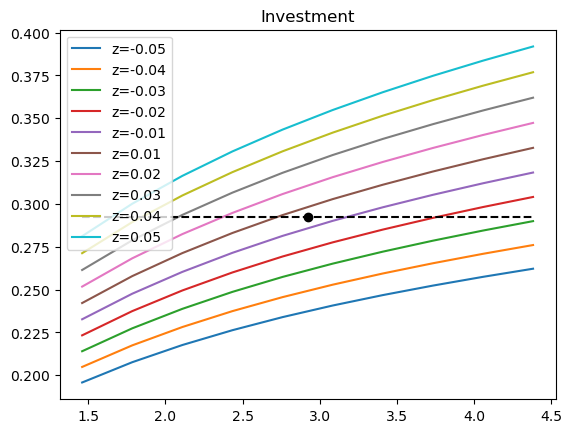

In [58]:
ss,xx = steady_state(m)
for i in range(10):
    plt.plot(grid[1], sol_0[i,:,0], label=f"z={grid[0][i]:.2f}")
plt.plot(grid[1], x0[0,:,0], linestyle='--', color='black')
plt.scatter([ss[1]], [xx[0]], color='black')
plt.legend(loc='upper left')
plt.title("Investment")